In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.nn.functional import affine_grid, grid_sample, conv2d
from sim_moving_v2 import *

In [2]:
from crop import *
crop = Crop(digit_size=28, frame_size=64, CUDA=False, device=None)

In [3]:
num_videoes = 10000
T = 10
num_digits = 1
step_length = 0.2
frame_size = 64
PATH = '/home/hao/Research/amortized/Moving-MNIST/data/'
simulator = BouncingMNIST(path=PATH, timesteps=T, num_digits=num_digits, step_length=step_length)

In [4]:
B = 3
S = 2
# T = 10
z_where = []
for i in range(B*S):
    X, _ = simulator.sim_trajectory()
    z_where.append(X.unsqueeze(0))
z_where = torch.cat(z_where, 0).view(S, B, 10, 2)

mnist = simulator.load_mnist()
digit = torch.from_numpy(mnist[150:150+S*B]).float().view(S, B, 28, 28)

In [5]:
z_where.shape

torch.Size([2, 3, 10, 2])

In [6]:
digit.shape

torch.Size([2, 3, 28, 28])

In [7]:
frames = crop.digit_to_frame(digit, z_where)

In [8]:
frames.shape

torch.Size([2, 3, 10, 64, 64])

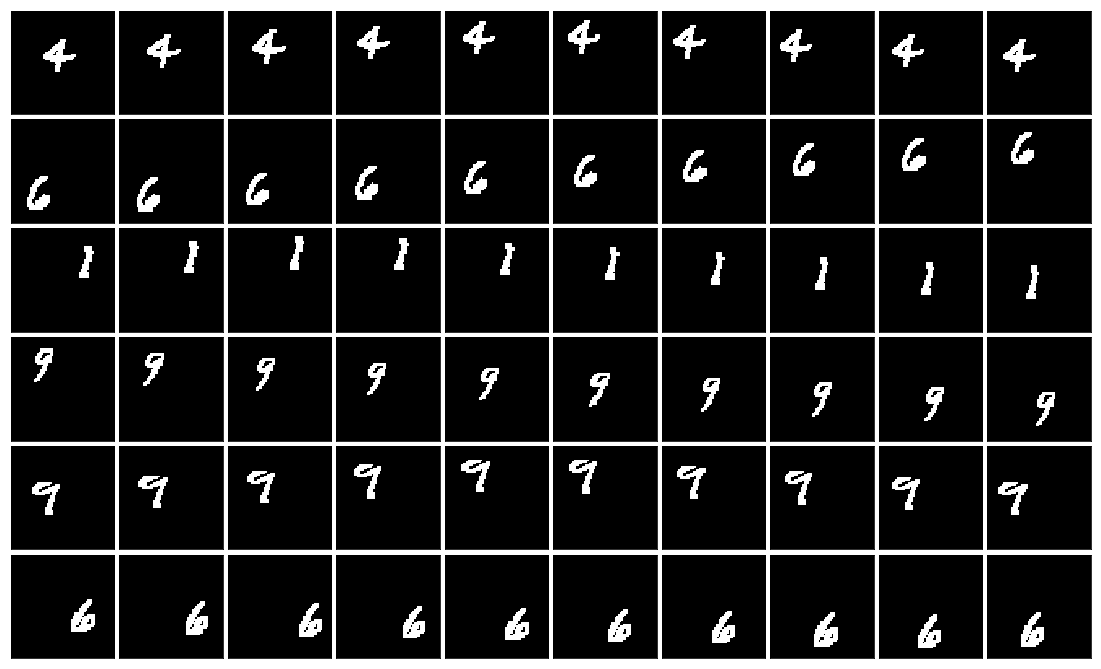

In [9]:
videoes = frames.view(S*B, T, 64, 64)
num_cols = T
num_rows = S*B
fs = 15
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(fs, fs * num_rows / num_cols))
for i in range(num_rows):
    for j in range(num_cols):
        ax = fig.add_subplot(gs[i, j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(videoes[i, j, :, :], cmap='gray', vmin=0.0, vmax=1.0)

torch.Size([3, 10, 28, 28])


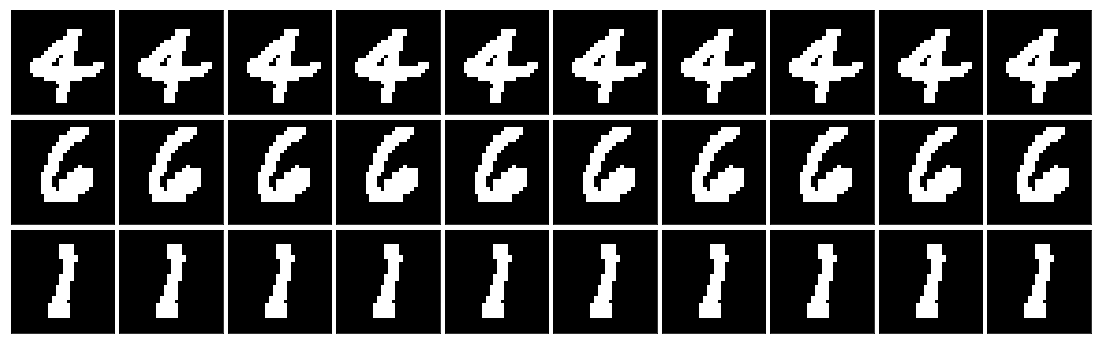

In [12]:
digit_re = crop.frame_to_digit(frames[0], z_where[0].unsqueeze(0)).squeeze(0)
print(digit_re.shape)
num_cols = T
num_rows = 1*B
fs = 15
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(fs, fs * num_rows / num_cols))
for i in range(num_rows):
    for j in range(num_cols):
        ax = fig.add_subplot(gs[i, j])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(digit_re[i, j, :, :], cmap='gray', vmin=0.0, vmax=1.0)

In [ ]:
# num_cols = T
# num_rows = S*B
# coor = z_where.view(S*B, T, 2)
# fs = 15
# gs = gridspec.GridSpec(num_rows, num_cols)
# gs.update(left=0.0 , bottom=0.0, right=1.0, top=1.0, wspace=0.05, hspace=0.05)
# fig = plt.figure(figsize=(fs, fs * num_rows / num_cols))
# for i in range(num_rows):
#     for j in range(num_cols):
#         ax = fig.add_subplot(gs[i, j])
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.scatter(coor[i, j, 0], coor[i, j, 1])
#         ax.set_xlim([-1,1])
#         ax.set_ylim([-1, 1])

In [ ]:
# simulator.viz_moving_mnist(fs=15, num_videoes=5)

In [ ]:
# simulator.save_data(num_videoes=num_videoes)

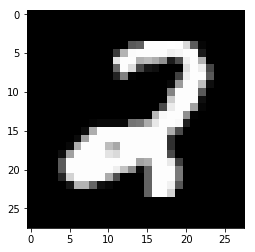

In [13]:
a = simulator.load_mnist()[325]
plt.imshow(a, cmap='gray')

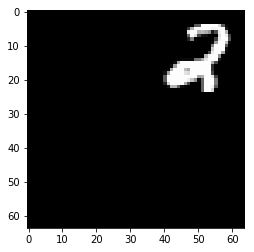

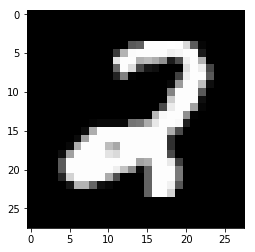

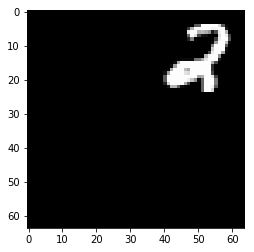

In [14]:
# digit to frame
theta = torch.Tensor([[64/28, 0, -1*(64/28)*(36/64)], [0, 64/28, 1*(64/28)*(36/64)]])
grid = affine_grid(theta.unsqueeze(0), torch.Size((1, 1, 64, 64)))
output = grid_sample(torch.from_numpy(a).float().unsqueeze(0).unsqueeze(0), grid, mode='nearest')[0,0]
plt.imshow(output.data.numpy(), cmap='gray')
plt.show()
# # frame to digit
theta2 = torch.Tensor([[(28/64), 0, 1*(36/64)], [0, (28/64), -1*(36/64)]])
grid2 = affine_grid(theta2.unsqueeze(0), torch.Size((1, 1, 28, 28)))
output2 = grid_sample(output.unsqueeze(0).unsqueeze(0), grid2, mode='nearest')[0,0]
plt.imshow(output2.data.numpy(), cmap='gray')
plt.show()
## analytical solution
x = 1.
y = 0.0
top = int(y * 36)
left = int(x * 36)
canvas = np.zeros((64, 64))
canvas[top:top+28, left:left+28] = a
plt.imshow(canvas, cmap='gray')
plt.show()

In [15]:
z_where = torch.Tensor([1., 1.])
frame = crop.digit_to_frame(torch.from_numpy(a).float().unsqueeze(0).unsqueeze(0), z_where.unsqueeze(0).unsqueeze(0).unsqueeze(0))

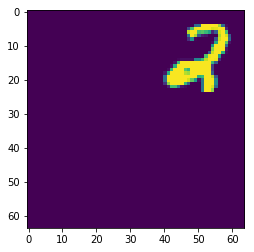

In [16]:
plt.imshow(frame[0,0,0])

In [17]:
digit_re = crop.frame_to_digit(frame[0], z_where.unsqueeze(0).unsqueeze(0).unsqueeze(0))

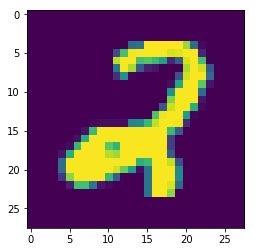

In [18]:
plt.imshow(digit_re[0,0,0])

In [ ]:
import torch.nn.functional as F
imgs = torch.randn((10, 2, 28, 28)) # T * B * H * W
kernels = torch.randn((6*2, 1, 3, 3)) # (S*B) * 1 * H * W
c = F.conv2d(imgs, kernels, groups=2)
c.shape
a = F.conv2d(imgs[:, 0, :, :].unsqueeze(1), kernels[:6, :, :, :])
b = F.conv2d(imgs[:, 1, :, :].unsqueeze(1), kernels[6:, :, :, :])

In [ ]:
torch.abs(a-b).sum()

In [ ]:
torch.abs(c[:, :6, :, :] - a).sum()

In [ ]:
torch.abs(c[:, 6:, :, :] - b).sum()